In [1]:
import numpy as np
import pandas as pd
from glob import glob 
from tqdm import tqdm
import seaborn as sns 

# for converting the text file containing the quarry locations into csv file
import csv

# for computing the geographical distance between two points 
import math


from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from datetime import datetime
import h5py
from sklearn.preprocessing import LabelEncoder
from scipy import stats, signal
from sklearn.preprocessing import StandardScaler
import obspy
from obspy.geodetics.base import gps2dist_azimuth, gps2dist_azimuth
from obspy.clients.fdsn import Client
import time
pd.set_option('display.max_columns', None)
from joblib import dump, load
from obspy.signal.filter import envelope
import tsfel


import sys
sys.path.append('../feature_extraction_scripts/physical_feature_extraction_scripts')
sys.path.append('../common_scripts')
import seis_feature
#from seis_feature import compute_physical_features
from tsfel import time_series_features_extractor, get_features_by_domain
from datetime import timedelta
import os


from common_processing_functions import apply_cosine_taper
from common_processing_functions import butterworth_filter

import pickle
from zenodo_get import zenodo_get

In [46]:
## Downloading the physical features 

# Define the Zenodo record DOI
doi = '10.5281/zenodo.11193585'  ## This is for physical features


## This is doi for tsfel features of 50s window length - 10.5281/zenodo.10689673
## This is doi for tsfel features of 150s window length - 10.5281/zenodo.10689824

# Download files from the Zenodo record
files = zenodo_get([doi])


Title: Physical Features for my study on Automatic Seismic Event Classification System in Pacific Northwest (Origin time - 50, +100)
Keywords: 
Publication date: 2024-05-14
DOI: 10.5281/zenodo.11193585
Total size: 179.7 MB

Link: https://zenodo.org/record/11193585/files/new_physical_features_exotic_z_50_100.csv   size: 6.9 MB

Checksum is correct. (ba4427cce08202f12ed96eb8e0ada953)

Link: https://zenodo.org/record/11193585/files/new_physical_features_comcat_z_explosion_50_100.csv   size: 11.7 MB

Checksum is correct. (b98eb04772713626a9102d11f50cdddb)

Link: https://zenodo.org/record/11193585/files/new_physical_features_noise_z_50_100.csv   size: 38.1 MB

Checksum is correct. (36a8f8c93828712699c56682c8403f56)

Link: https://zenodo.org/record/11193585/files/new_physical_features_earthquake_z_part3_50_100.csv   size: 35.9 MB

Checksum is correct. (495e768402c1128600997c7cf06b9c32)

Link: https://zenodo.org/record/11193585/files/new_physical_features_earthquake_z_part2_50_100.csv   size:

## Loading physical features

In [3]:
# extracting features of surface events, thunder and sonic booms
features_exotic_physical = pd.read_csv('../extracted_features/physical_features_exotic_P_10_30_F_1_15_50.csv')

features_surface_physical = features_exotic_physical[features_exotic_physical['source'] == 'surface']
features_sonic_physical = features_exotic_physical[features_exotic_physical['source'] == 'sonic']
features_thunder_physical = features_exotic_physical[features_exotic_physical['source'] == 'thunder']



# features of noise
features_noise_physical = pd.read_csv('../extracted_features/physical_features_noise_P_10_30_F_1_15_50.csv')


# features of explosion
features_explosion_physical = pd.read_csv('../extracted_features/physical_features_explosion_P_10_30_F_1_15_50.csv')

# features of earthquakes
features_eq1 = pd.read_csv('../extracted_features/physical_features_earthquake_part_1_P_10_30_F_1_15_50.csv')
features_eq2 = pd.read_csv('../extracted_features/physical_features_earthquake_part_2_P_10_30_F_1_15_50.csv')
features_eq3 = pd.read_csv('../extracted_features/physical_features_earthquake_part_3_P_10_30_F_1_15_50.csv')
features_eq4 = pd.read_csv('../extracted_features/physical_features_earthquake_part_4_P_10_30_F_1_15_50.csv')

features_earthquake_physical = pd.concat([features_eq1, features_eq2, features_eq3, features_eq4])

In [4]:
features_all = pd.concat([features_surface_physical, features_noise_physical, features_explosion_physical, features_earthquake_physical])
features_all = features_all.drop(['Unnamed: 0'], axis = 1)
print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')

So we have 230373 events and each event have 64 features


## Removing the downloaded files to clean up the directory

In [5]:
# Get the current working directory
directory = os.getcwd()

# List the files in the directory
files = os.listdir(directory)

# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".csv"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)


## Preprocessing the input features

In [6]:
# dropping the columns that contain NaNs
features_all = features_all.dropna(axis = 1)

# dropping the rows that contains NaNs
features_all = features_all.dropna()


## dropping all the rows containing infinity values
features_all = features_all.replace([np.inf, -np.inf], np.nan).dropna()


## dropping sonic boom and thunder events
features_all = features_all[features_all['source'] != 'sonic']
features_all = features_all[features_all['source'] != 'thunder']

print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')


So we have 229149 events and each event have 63 features


## Dropping the columns that contain same values for all the events, as these features do not really contribute in classification

In [7]:
# Check unique values in each column
unique_counts = features_all.nunique()

# Identify columns with only one unique value (same value for all rows)
single_value_columns = unique_counts[unique_counts == 1].index


# Drop columns with the same value for all rows
features_all = features_all.drop(columns=single_value_columns)

print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')


So we have 229149 events and each event have 60 features


## Data Cleaning (Optional)

In [8]:
df = features_all.drop(['serial_no', 'source'], axis = 1)
# Calculate Z-scores for each feature
z_scores = np.abs(stats.zscore(df))


# Define a threshold for Z-score beyond which data points are considered outliers
threshold = 10

# Filter out rows with any Z-score greater than the threshold
# Temporarily removing this 
outliers_removed_df =   features_all[(z_scores < threshold).all(axis=1)]

print(len(features_all))
print(len(outliers_removed_df))


229149
227732


# Removing Highly Correlated Features

In [9]:
df = outliers_removed_df.drop(['serial_no', 'source'], axis = 1)
correlation_matrix = df.corr().abs()
highly_correlated = np.where(correlation_matrix >= 0.8)
columns = df.columns

to_drop = []
for i, j in zip(*highly_correlated):
    if i != j and i not in to_drop and j not in to_drop:
        to_drop.append(columns[j])

df_filtered = df.drop(to_drop, axis=1)

print(f'So we now have {df_filtered.shape[0]} events and each event have {df_filtered.shape[1]} features')
df_filtered['serial_no'] = outliers_removed_df['serial_no'].values
df_filtered['source'] = outliers_removed_df['source'].values

## Lets not remove the outliers for a bit
new_df = df_filtered


So we now have 227732 events and each event have 32 features


In [10]:
new_df = outliers_removed_df

## Standardizing the features

In [11]:
## defining the global variables X and y
X = new_df.drop(['serial_no','source'], axis = 1)
y = new_df['source']


# Initialize the StandardScaler
scaler = StandardScaler()



# Apply standard scaling to the DataFrame
scaled_features = scaler.fit_transform(X)


# Access the mean and standard deviation for each feature
means = scaler.mean_
std_devs = scaler.scale_

# Create a DataFrame to display the means and standard deviations
scaler_params = pd.DataFrame({'Feature': X.columns, 'Mean': means, 'Std Dev': std_devs})
print(scaler_params)


# Create a new DataFrame with scaled features
X_scaled = pd.DataFrame(scaled_features, columns=X.columns)


## We are not standardizing at this stage. We will rather wait when the outlier are removed, then we will
## standardize and save the standard scaler parameters. 
#X_scaled = X

X_scaled['serial_no'] = outliers_removed_df['serial_no'].values
X_scaled['source'] = outliers_removed_df['source'].values

                       Feature         Mean       Std Dev
0                  RappMaxMean     5.303970      3.161615
1                RappMaxMedian    13.280963     27.211092
2                        AsDec     2.660671      8.910460
3                     KurtoSig    21.866402     29.822287
4                     KurtoEnv     6.615571      6.436247
5                      SkewSig    -0.036478      0.837885
6                      SkewEnv     1.847595      1.645100
7                CorPeakNumber   305.564593    111.338398
8                 Energy1/3Cor    -0.375098     28.700094
9                 Energy2/3Cor     0.185959     28.501087
10                   int_ratio    -0.496209     55.749184
11             RMSDecPhaseLine     0.928860      2.972049
12                     MeanFFT     3.987713      1.823607
13                      MaxFFT    37.932600     31.156214
14                     FMaxFFT     4.981808      3.500188
15                   MedianFFT     0.000557      0.000181
16            

## Merging the metadata information

In [12]:
# extracting the stored data
comcat_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5",'r')
exotic_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5",'r')
noise_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5",'r')


# extracting the catalog
comcat_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")
exotic_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
noise_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")



# extracting the metadata corresponding to individual events
cat_exp = comcat_file_csv[comcat_file_csv['source_type'] == 'explosion']
cat_eq = comcat_file_csv[comcat_file_csv['source_type'] == 'earthquake']
cat_no = noise_file_csv
cat_su = exotic_file_csv[exotic_file_csv['source_type'] == 'surface event']



# extracting the index 
ind_exp = X_scaled[X_scaled['source'] == 'explosion']['serial_no'].values
ind_eq = X_scaled[X_scaled['source'] == 'earthquake']['serial_no'].values
ind_no = X_scaled[X_scaled['source'] == 'noise']['serial_no'].values
ind_su = X_scaled[X_scaled['source'] == 'surface']['serial_no'].values


df_exp = X_scaled[X_scaled['source'] == 'explosion']
exp_df = cat_exp.iloc[ind_exp]
exp_df['serial_no'] = ind_exp


df_eq = X_scaled[X_scaled['source'] == 'earthquake']
eq_df = cat_eq.iloc[ind_eq]
eq_df['serial_no'] = ind_eq



df_no = X_scaled[X_scaled['source'] == 'noise']
no_df = cat_no.iloc[ind_no]
no_df['serial_no'] = ind_no



df_su = X_scaled[X_scaled['source'] == 'surface']
su_df = cat_su.iloc[ind_su]
su_df['serial_no'] = ind_su





new_exp = pd.merge(df_exp,exp_df, on = 'serial_no')
new_eq = pd.merge(df_eq,eq_df, on = 'serial_no')
new_su = pd.merge(df_su,su_df, on = 'serial_no')
new_no = pd.merge(df_no,no_df, on = 'serial_no')
new_no['event_id'] = np.array(['noise'+str(i) for i in np.arange(len(new_no))])



X_final = pd.concat([new_exp, new_eq, new_su, new_no])
y = ['explosion']*len(new_exp)+['earthquake']*len(new_eq)+['surface']*len(new_su)+['noise']*len(new_no)


/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


### Adding Hour of the Day, Days of Week and Month of Year as additional features as they have shown to significantly increase the performance of the machine learning model

In [13]:
# new_exp contains the features and the corresponding metadata information. 
datetimes = X_final['trace_start_time'].values

hour_of_day = []
days_of_week = []
month_of_year = []
for dt_str in tqdm(datetimes):
        
    # Parse the datetime string
        dt = datetime.strptime(dt_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        hod = dt.hour - 8.  # converting to local time. 
        moy = dt.month
        
        
        days_of_week.append(dt.weekday())
        hour_of_day.append(hod)
        month_of_year.append(moy)
        
X_final['hour_of_day'] = hour_of_day
X_final['day_of_week'] = days_of_week
X_final['month_of_year'] = month_of_year


100%|██████████| 227732/227732 [00:02<00:00, 89009.48it/s]


In [14]:
temp_X = X_final.iloc[:,0:31]
#temp_X = temp_X.assign(hod=X_final['hour_of_day'].values, dow=X_final['day_of_week'].values, moy=X_final['month_of_year'].values)



# Initialize the StandardScaler
scaler = StandardScaler()

# Apply standard scaling to the DataFrame
scaled_features = scaler.fit_transform(temp_X)

# Create a new DataFrame with scaled features
temp_X = pd.DataFrame(scaled_features, columns= temp_X.columns)



## So X_final that contains the features and corresponding metadata information for all the events

### hyperparameter tuning of the model based on 3000 samples per class and splitting into 80-20%.

In [15]:
# Apply random undersampling using imbalanced-learn library
rus = RandomUnderSampler(sampling_strategy={'earthquake':3000, 'explosion':3000, 'surface':3000, 'noise':3000})
X_resampled, y_resampled = rus.fit_resample(temp_X, y)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num = label_encoder.fit_transform(y_resampled)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_num, test_size=0.2, stratify = y_num)



# Define the hyperparameter grid for randomized search
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize the RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=50, scoring='f1_macro', cv=10, verbose=0, random_state=42, n_jobs=-1
)

# Perform randomized grid search cross-validation
random_search.fit(X_train, y_train)

# Print the best parameters and their corresponding accuracy score
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Test Accuracy:", accuracy)




Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}
Best Accuracy: 0.862117150521
Test Accuracy: 0.8625


### Performance with best model

Text(0.5, 1.0, 'Total samples: 2400')

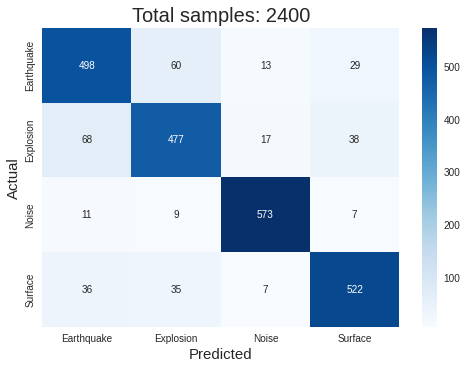

In [16]:
## Performance with best model

plt.style.use('seaborn')
cm = confusion_matrix(y_test, y_pred)


labels = ['Earthquake', 'Explosion','Noise','Surface']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels = labels, yticklabels = labels)
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Actual', fontsize = 15)
plt.title('Total samples: '+str(len(y_pred)), fontsize = 20)



### Classification report with best model

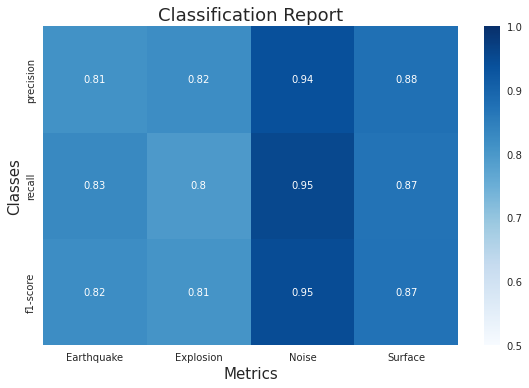

In [17]:
# Calculate the classification report
report = classification_report(y_test, y_pred, output_dict=True)
labels = ['Earthquake', 'Explosion', 'Noise','Surface']

# Set a pleasing style
sns.set_style("whitegrid")

# Create a figure and axes for the heatmap
plt.figure()
ax = sns.heatmap(pd.DataFrame(report).iloc[:3, :4], annot=True, cmap='Blues', xticklabels=labels, vmin=0.5, vmax=1)

# Set labels and title
ax.set_xlabel('Metrics', fontsize=15)
ax.set_ylabel('Classes', fontsize=15)
ax.set_title('Classification Report', fontsize=18)

# Create a colorbar
#cbar = ax.collections[0].colorbar
#cbar.set_ticks([0.5, 1])  # Set custom tick locations
#cbar.set_ticklabels(['0', '0.5', '1'])  # Set custom tick labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## In the following code, we are randomly selecting 5000 "Events" per class,  and separating them from the testing dataset

In [18]:
## extracting metadata information for each kind of source along with features
a_eq = X_final[X_final['source_type_pnsn_label'] == 'eq']
a_px = X_final[X_final['source_type_pnsn_label'] == 'px']
a_su = X_final[X_final['source_type'] == 'surface event']
a_no = X_final[X_final['source_type'] == 'noise']



## extracting the event ids corresponding to each catalog
eq_ids = np.unique(a_eq['event_id'].values)
su_ids = np.unique(a_su['event_id'].values)
no_ids = np.unique(a_no['event_id'].values)
px_ids = np.unique(a_px['event_id'].values)


## defining the events for training and testing in 70:30 ratio


"""

Modifying this section a bit, for a fair comparison to deep neural network. 


train_eq = eq_ids[0:int(0.7*len(eq_ids))]
train_px = px_ids[0:int(0.7*len(px_ids))]
train_su = su_ids[0:int(0.7*len(su_ids))]
train_no = no_ids[0:int(0.7*len(no_ids))]


test_eq = eq_ids[int(0.7*len(eq_ids)):len(eq_ids)]
test_px = px_ids[int(0.7*len(px_ids)):len(px_ids)]
test_su = su_ids[int(0.7*len(su_ids)):len(su_ids)]
test_no = no_ids[int(0.7*len(no_ids)):len(no_ids)]


"""

## randomizing along the time. 
r1 = np.random.randint(0, len(eq_ids), 5000)
train_eq = eq_ids[r1]

## randomizing along the time. 
r2 = np.random.randint(0, len(px_ids), 5000)
train_px = px_ids[r2]

## randomizing along the time. 
r3 = np.random.randint(0, len(su_ids), 5000)
train_su = su_ids[r3]

## randomizing along the time
r4 = np.random.randint(0, len(no_ids), 5000)
train_no = no_ids[r4]



mask_eq = np.ones(eq_ids.shape, dtype = bool)
mask_eq[r1] = False

mask_px = np.ones(px_ids.shape, dtype = bool)
mask_px[r2] = False

mask_su = np.ones(su_ids.shape, dtype = bool)
mask_su[r3] = False

mask_no = np.ones(no_ids.shape, dtype = bool)
mask_no[r4] = False

test_eq = eq_ids[mask_eq]
test_px = px_ids[mask_px]
test_su = su_ids[mask_su]
test_no = no_ids[mask_no]



# concatenating training ids
all_train_ids = np.concatenate([train_eq,train_px, train_su, train_no])

# concatenating testing ids
all_test_ids = np.concatenate([test_eq,test_px, test_su, test_no])

# allocating event id as index
X_final.index = X_final['event_id'].values


# extracting training and testing values
X_train = X_final.loc[all_train_ids]
X_test = X_final.loc[all_test_ids]



Y_train = X_train['source_type'].values
Y_test = X_test['source_type'].values

In [19]:
# Case 1: without adding anything manual
## Check the performance 
x_train = X_train.iloc[:, 0:31]
#x_train = x_train.assign(hod=X_train['hour_of_day'].values, dow=X_train['day_of_week'].values, moy=X_train['month_of_year'].values)

x_test = X_test.iloc[:, 0:31]
#x_test = x_test.assign(hod=X_test['hour_of_day'].values, dow=X_test['day_of_week'].values, moy=X_test['month_of_year'].values)



## Training the model on 5000 randomly samples waveforms per class and testing it on the remaining dataset

In [20]:
# initiating a random undersampler
rus = RandomUnderSampler(sampling_strategy={'earthquake':5000, 'explosion':5000,'surface event':5000,'noise':5000}, random_state = 42)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Converting the textual labels into numerical labels
y_num_test = label_encoder.fit_transform(Y_test)


# randomly taking 5000 samples per class from the training dataset
X_resampled, y_resampled = rus.fit_resample(x_train, Y_train)


# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num_res = label_encoder.fit_transform(y_resampled)



best_model.class_weight  = None
best_model.fit(X_resampled, y_num_res)




RandomForestClassifier(bootstrap=False, n_estimators=500, random_state=42)

## Trace wise performance

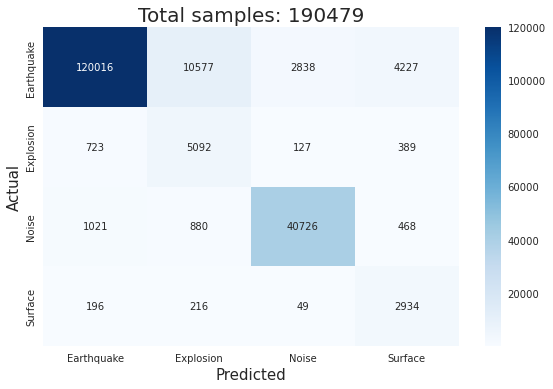

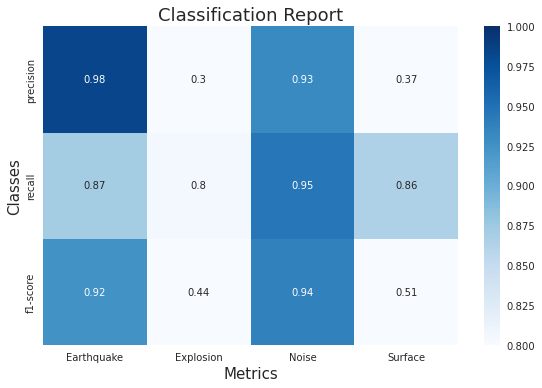

In [21]:
y_pred = best_model.predict(x_test)
plt.style.use('seaborn')
trace_cm_phy = confusion_matrix(y_num_test, y_pred)


event_labels = ['Earthquake', 'Explosion','Noise','Surface']
plt.figure()
sns.heatmap(trace_cm_phy, annot=True, cmap='Blues', fmt='d', xticklabels = event_labels, yticklabels = event_labels)
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Actual', fontsize = 15)
plt.title('Total samples: '+str(len(y_pred)), fontsize = 20)
# Adjust layout
plt.tight_layout()



# Calculate the classification report
trace_report_phy = classification_report(y_num_test, y_pred, output_dict=True)
labels = ['Precision', 'Recall', 'F1-Score']

# Set a pleasing style
sns.set_style("whitegrid")

# Create a figure and axes for the heatmap
plt.figure()
ax = sns.heatmap(pd.DataFrame(trace_report_phy).iloc[:3, :4], annot=True, cmap='Blues', xticklabels= event_labels, vmin=0.8, vmax=1)

# Set labels and title
ax.set_xlabel('Metrics', fontsize=15)
ax.set_ylabel('Classes', fontsize=15)
ax.set_title('Classification Report', fontsize=18)

# Create a colorbar
#cbar = ax.collections[0].colorbar
#cbar.set_ticks([0.5, 1])  # Set custom tick locations
#cbar.set_ticklabels(['0', '0.5', '1'])  # Set custom tick labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Event wise performance

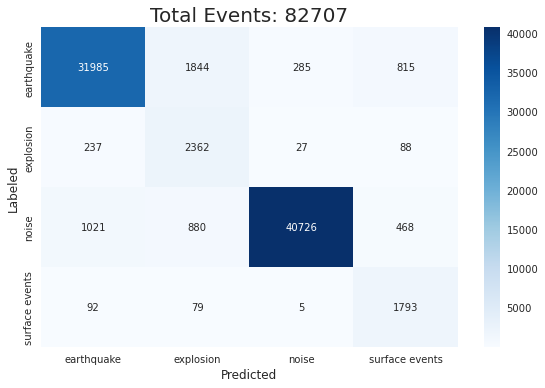

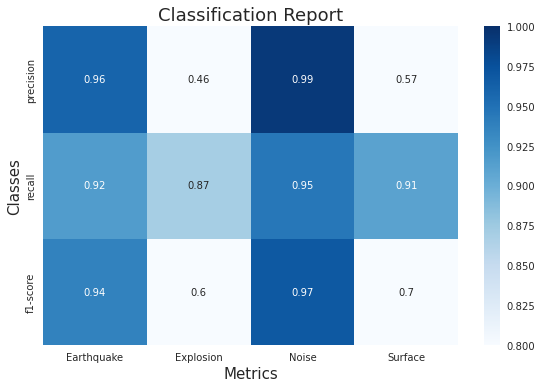

In [22]:
probs_all = best_model.predict_proba(x_test)

X_test['labelled'] = y_num_test
X_test['classified'] = y_pred
X_test['eq_probability'] = probs_all[:,0]
X_test['px_probability'] = probs_all[:,1]
X_test['no_probability'] = probs_all[:,2]
X_test['su_probability'] = probs_all[:,3]


mean_labels = X_test.groupby('event_id').mean()['labelled'].values
mean_ids = X_test.groupby('event_id').mean().index.values



mean_eq_prob = X_test.groupby('event_id').mean()['eq_probability'].values
mean_px_prob = X_test.groupby('event_id').mean()['px_probability'].values
mean_no_prob = X_test.groupby('event_id').mean()['no_probability'].values
mean_su_prob = X_test.groupby('event_id').mean()['su_probability'].values



temp_class = np.argmax(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)
temp_probs = np.max(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)



cf_events_phy = confusion_matrix(mean_labels, temp_class)
cf_norm = cf_events_phy/np.sum(cf_events_phy, axis = 1, keepdims = True)
labels = ['earthquake','explosion','noise','surface events']

plt.figure()
ax = sns.heatmap(cf_events_phy, annot = True, cmap='Blues', xticklabels = labels, yticklabels = labels,  fmt="1.0f")
ax.set_xlabel('Predicted', fontsize = 12)
ax.set_ylabel('Labeled', fontsize = 12)
ax.set_title('Total Events: '+str(len(mean_labels)), fontsize = 20)
plt.tight_layout()




# Calculate the classification report
report_event_phy = classification_report(mean_labels, temp_class, output_dict=True)
labels = ['Precision', 'Recall', 'F1-Score']

# Set a pleasing style
sns.set_style("whitegrid")

# Create a figure and axes for the heatmap
plt.figure()
ax = sns.heatmap(pd.DataFrame(report_event_phy).iloc[:3, :4], annot=True, cmap='Blues', xticklabels=event_labels, vmin=0.8, vmax=1)

# Set labels and title
ax.set_xlabel('Metrics', fontsize=15)
ax.set_ylabel('Classes', fontsize=15)
ax.set_title('Classification Report', fontsize=18)

# Create a colorbar
#cbar = ax.collections[0].colorbar
#cbar.set_ticks([0.5, 1])  # Set custom tick locations
#cbar.set_ticklabels(['0', '0.5', '1'])  # Set custom tick labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Saving results of different models

In [68]:
# Saving every result into disk

# Saving trace results

## physical 
# Save to a file
with open('../results/trace_report_phy.pkl', 'wb') as pickle_file:
    pickle.dump(trace_report_phy, pickle_file)

    
# Save to a file
with open('../results/trace_confusion_matrix_phy.pkl', 'wb') as pickle_file:
    pickle.dump(trace_cm_phy, pickle_file)
    
    

# Saving event results

with open('../results/event_report_phy.pkl', 'wb') as pickle_file:
    pickle.dump(report_event_phy, pickle_file)

    

with open('../results/event_confusion_matrix_phy.pkl', 'wb') as pickle_file:
    pickle.dump(cf_events_phy, pickle_file)

    
